- Wine, Irises
- 3D to rotate
- Many errors
    - Ларс/лассо
    - Набор признаков оптимальный - фиксируем количество
    - Построить два графика - при всех n могут быть колебания, при оптимальном - плато

In [1]:
import os

import numpy as np
import pandas as pd

import utils_ss as ut
import m_models as mm

from tqdm import tqdm_notebook as tqdm

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d    

%matplotlib notebook

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

In [38]:
def set_plt_params():
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 8
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 26
    plt.rcParams['axes.titlesize']=20
    plt.rcParams['axes.labelsize']=26
    plt.rcParams['font.size'] = 26
    plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [5]:
labels_for_plot = {
                    'cross': "$\mathsf{E}_{\mathfrak{D}_m}RS(m)$",
                    'apvc': "$\mathsf{E}_{\mathfrak{D}_m}\mathsf{D}[\hat{w}|\mathfrak{D}_m]$",
                    'acc': "$\mathsf{E}_{\mathfrak{D}_m}\mathsf{P}\{w \in A_{l}(\hat{w})\}$",
                    'alc': "$\mathsf{E}_{\mathfrak{D}_m}r_m$",
                    'maxu': "$\mathsf{E}_{\mathfrak{D}_m}\int_{w}u(\mathfrak{D}_m, w)p(w|\mathfrak{D}_m)dw$",
                    'kl': "$\mathsf{E}_{\mathfrak{D}_m}D_{KL}(p_1, p_2)$",
                    'bootstrap': "$\mathsf{E}_{\mathfrak{D}_m}$",
                    }

## Boston dataset

In [6]:
name = 'boston'
X, y = ut.DataLoader(name = name)
X, y = ut.preprocess(X, y)

print(X.shape)

methods = {'lagrange': lambda X, y: mm.lagrange(X, y),
            'ratio': lambda X, y: mm.likelihood_ratio(X, y),
            'wald': lambda X, y: mm.wald(X, y),
            'cross': lambda X, y: mm.cross_val(X, y, k_for_meaning=1000, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'apvc': lambda X, y: mm.APVC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'acc': lambda X, y: mm.ACC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'alc': lambda X, y: mm.ALC(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'maxu': lambda X, y: mm.MAX_U(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'kl': lambda X, y: mm.KL_method(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'bootstrap': lambda X, y: mm.bootstrap(X, y, num = 2, progress_bar=lambda x: tqdm(x, leave = False)),
            'logistic': lambda X, y: mm.LogisticRegressionMethod(X, y),
          }

(506, 12)


### Observation of model weights

In [7]:
boston_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [8]:
len(boston_df)

506

In [9]:
def test_linear_model_weights(data, init_size, step, num_of_tests=1):        
    weights = [[]]
    
    train_data = []
    chosen_data = []
    for i in range(num_of_tests):
        train_data.append(data.sample(n=init_size, random_state=i))
        chosen_data.append(np.array(train_data[i].index))
    
        model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
        weights[0].append(model.coef_)
    
    x = [0]
    for k, j in enumerate(range(init_size, len(data)+1, step)):
        weights.append([])
        
        sample_size = min(step, len(data)-j)
        for i in range(num_of_tests):
            add_data = data.loc[~data.index.isin(chosen_data[i])].sample(n=sample_size, random_state=i)
            chosen_data[i] = np.concatenate((chosen_data[i], add_data.index))
            train_data[i] = pd.concat((train_data[i], add_data))

            model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
            weights[k+1].append(model.coef_)
            
        x.append(j)
     
    x = np.array(x)
    x = x / max(x) * 100
    return np.array(weights), x

In [22]:
boston_weights, x = test_linear_model_weights(boston_df, 1, 5, num_of_tests=50)

In [23]:
set_plt_params()

<IPython.core.display.Javascript object>


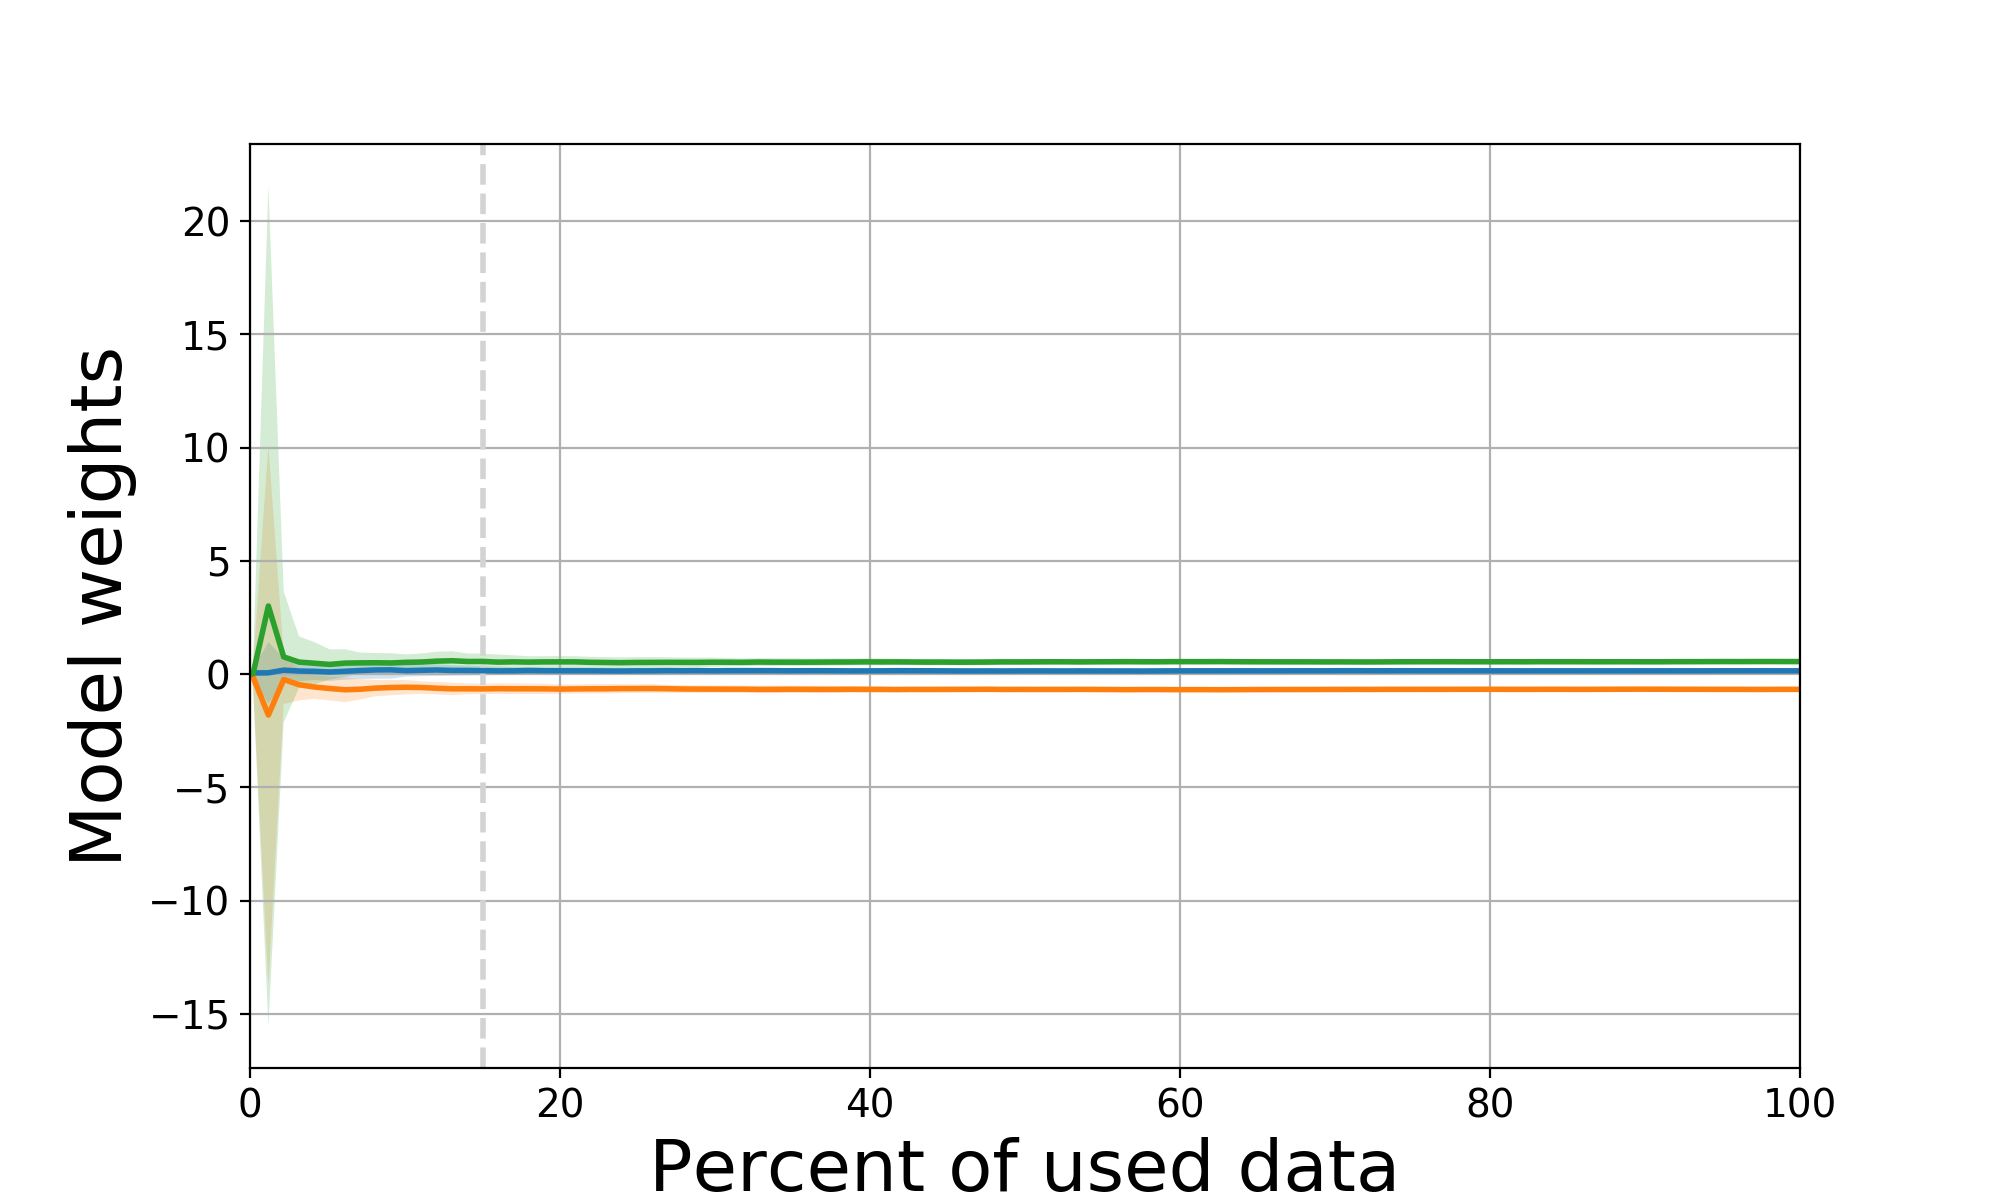

In [25]:
plt.axvline(x=15, linestyle='dashed', color='lightgrey')

chosen_weights = [3,6,7]
    
mean = np.mean(boston_weights, axis=1)
std = np.std(boston_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [26]:
def test_linear_model_error(data, init_size, step, test_data, num_of_tests=1):    
    error = [[]]
    
    train_data = []
    chosen_data = []
    for i in range(num_of_tests):
        train_data.append(data.sample(n=init_size, random_state=i))
        chosen_data.append(np.array(train_data[i].index))
    
        model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
        error[0].append(mean_squared_error(model.predict(test_data.iloc[:,:-1]), test_data.iloc[:,-1]))
    
    x = [0]
    for k, j in enumerate(range(init_size, len(data)+1, step)):
        error.append([])
        
        sample_size = min(step, len(data)-j)
        for i in range(num_of_tests):
            add_data = data.loc[~data.index.isin(chosen_data[i])].sample(n=sample_size, random_state=i)
            chosen_data[i] = np.concatenate((chosen_data[i], add_data.index))
            train_data[i] = pd.concat((train_data[i], add_data))

            model = LinearRegression().fit(train_data[i].iloc[:,:-1], train_data[i].iloc[:,-1])
            error[k+1].append(mean_squared_error(model.predict(test_data.iloc[:,:-1]), test_data.iloc[:,-1]))
        x.append(j)
     
    x = np.array(x)
    x = x / max(x) * 100
    return np.array(error), x

In [27]:
boston_train = boston_df.sample(400, random_state=42)
boston_test = boston_df.loc[~boston_df.index.isin(boston_train.index)]

In [28]:
boston_error, x = test_linear_model_error(boston_train, 1, 5, boston_test, num_of_tests=50)

In [29]:
set_plt_params()

<IPython.core.display.Javascript object>


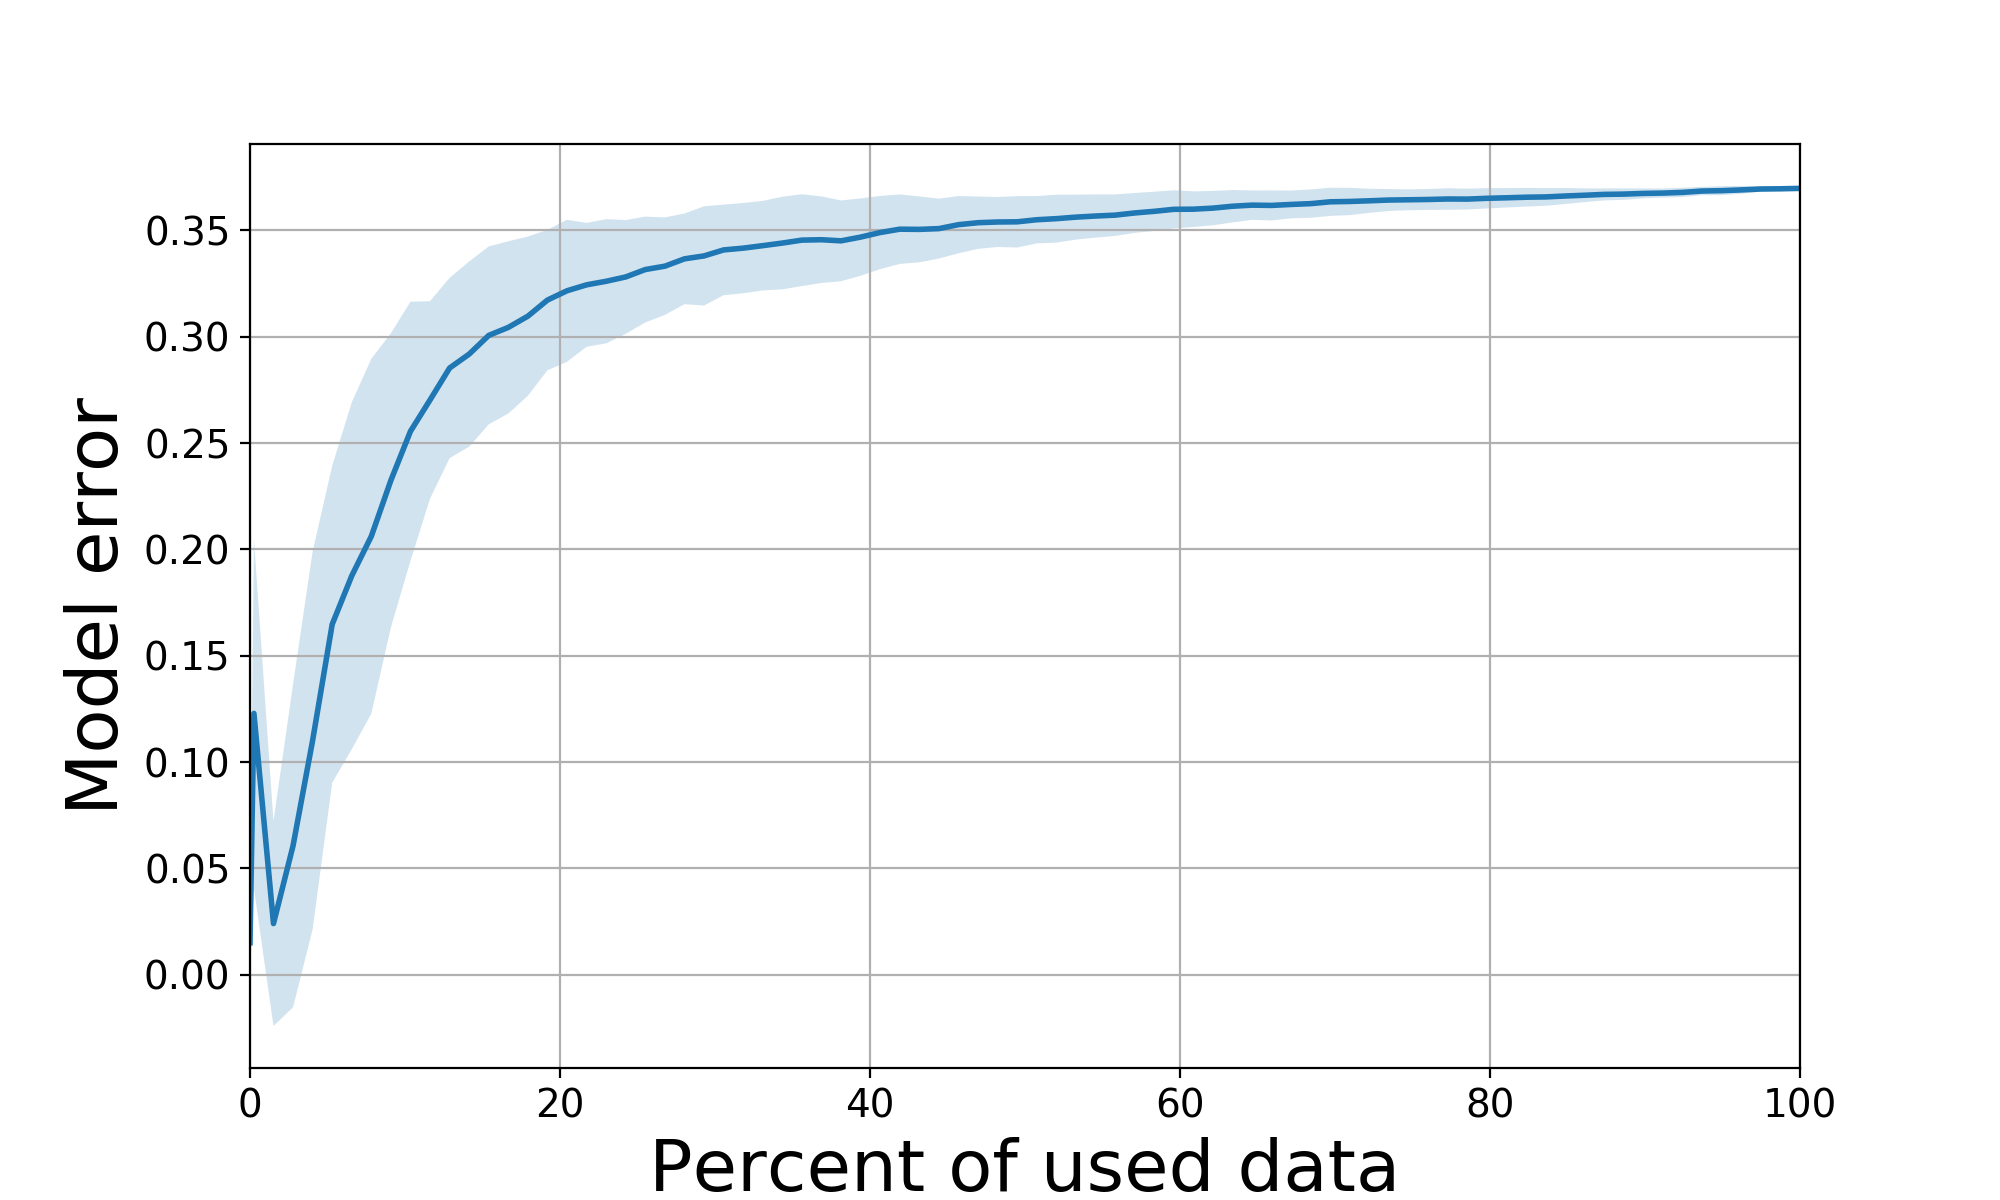

In [30]:
mean = np.mean(np.exp(-boston_error), axis=1)
std = np.std(np.exp(-boston_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [66]:
def test_linear_model_error_features(data, train_data, test_data, init_size, step, num_of_tests=1):  
    model = ut.LinearModel(data.iloc[:,-1], data.iloc[:,:-1])
    w = model.fit()
    features_order = np.absolute(w).argsort()[::-1].values
    
    answer = [len(features_order)]
    
    error = [[]]
    
    train_data_sampled = []
    chosen_data = []
    for l in range(1, len(features_order)+1):
        train_data_sampled.append([])
        chosen_data.append([])
        error[0].append([])
        
        for i in range(num_of_tests):
            train_data_sampled[l-1].append(train_data.iloc[:,list(features_order[:l])+answer]
                                           .sample(n=init_size, random_state=i))
            chosen_data[l-1].append(np.array(train_data_sampled[l-1][i].index))

            model = LinearRegression().fit(train_data_sampled[l-1][i].iloc[:,:-1], 
                                           train_data_sampled[l-1][i].iloc[:,-1])
            w = model.coef_
            error[0][l-1].append(mean_squared_error(model.predict(test_data.iloc[:,features_order[:l]]), 
                                                    test_data.iloc[:,-1]))
    
    size = [0]
    for k, j in enumerate(range(init_size+step, len(train_data)+1, step)):
        error.append([])
        
        sample_size = min(step, len(train_data)-j)
        for l in range(1, len(features_order)+1):
            error[k+1].append([])
            
            for i in range(num_of_tests):
                add_data = (train_data
                            .iloc[:,list(features_order[:l])+answer]
                            .loc[~train_data.iloc[:,list(features_order[:l])+answer].index.isin(chosen_data[l-1][i])]
                            .sample(n=sample_size, random_state=i)
                           )
                train_data_sampled[l-1][i] = pd.concat((train_data_sampled[l-1][i], add_data))
                chosen_data[l-1][i] = np.concatenate((chosen_data[l-1][i], add_data.index))

                model = LinearRegression().fit(train_data_sampled[l-1][i].iloc[:,:-1], 
                                               train_data_sampled[l-1][i].iloc[:,-1])
                w = model.coef_
                error[k+1][l-1].append(mean_squared_error(model.predict(test_data.iloc[:,features_order[:l]]),
                                                          test_data.iloc[:,-1]))
                                       
        size.append(j)
     
    features = list(range(1,len(features_order)+1))
    return np.array(error), features, size

In [35]:
boston_error, features, size = test_linear_model_error_features(boston_df, boston_train, boston_test, 
                                                                1, 5, num_of_tests=5)

In [59]:
matplotlib.style.use('default')
plt.rcParams['figure.figsize'] = (10.0, 7.0)

<IPython.core.display.Javascript object>


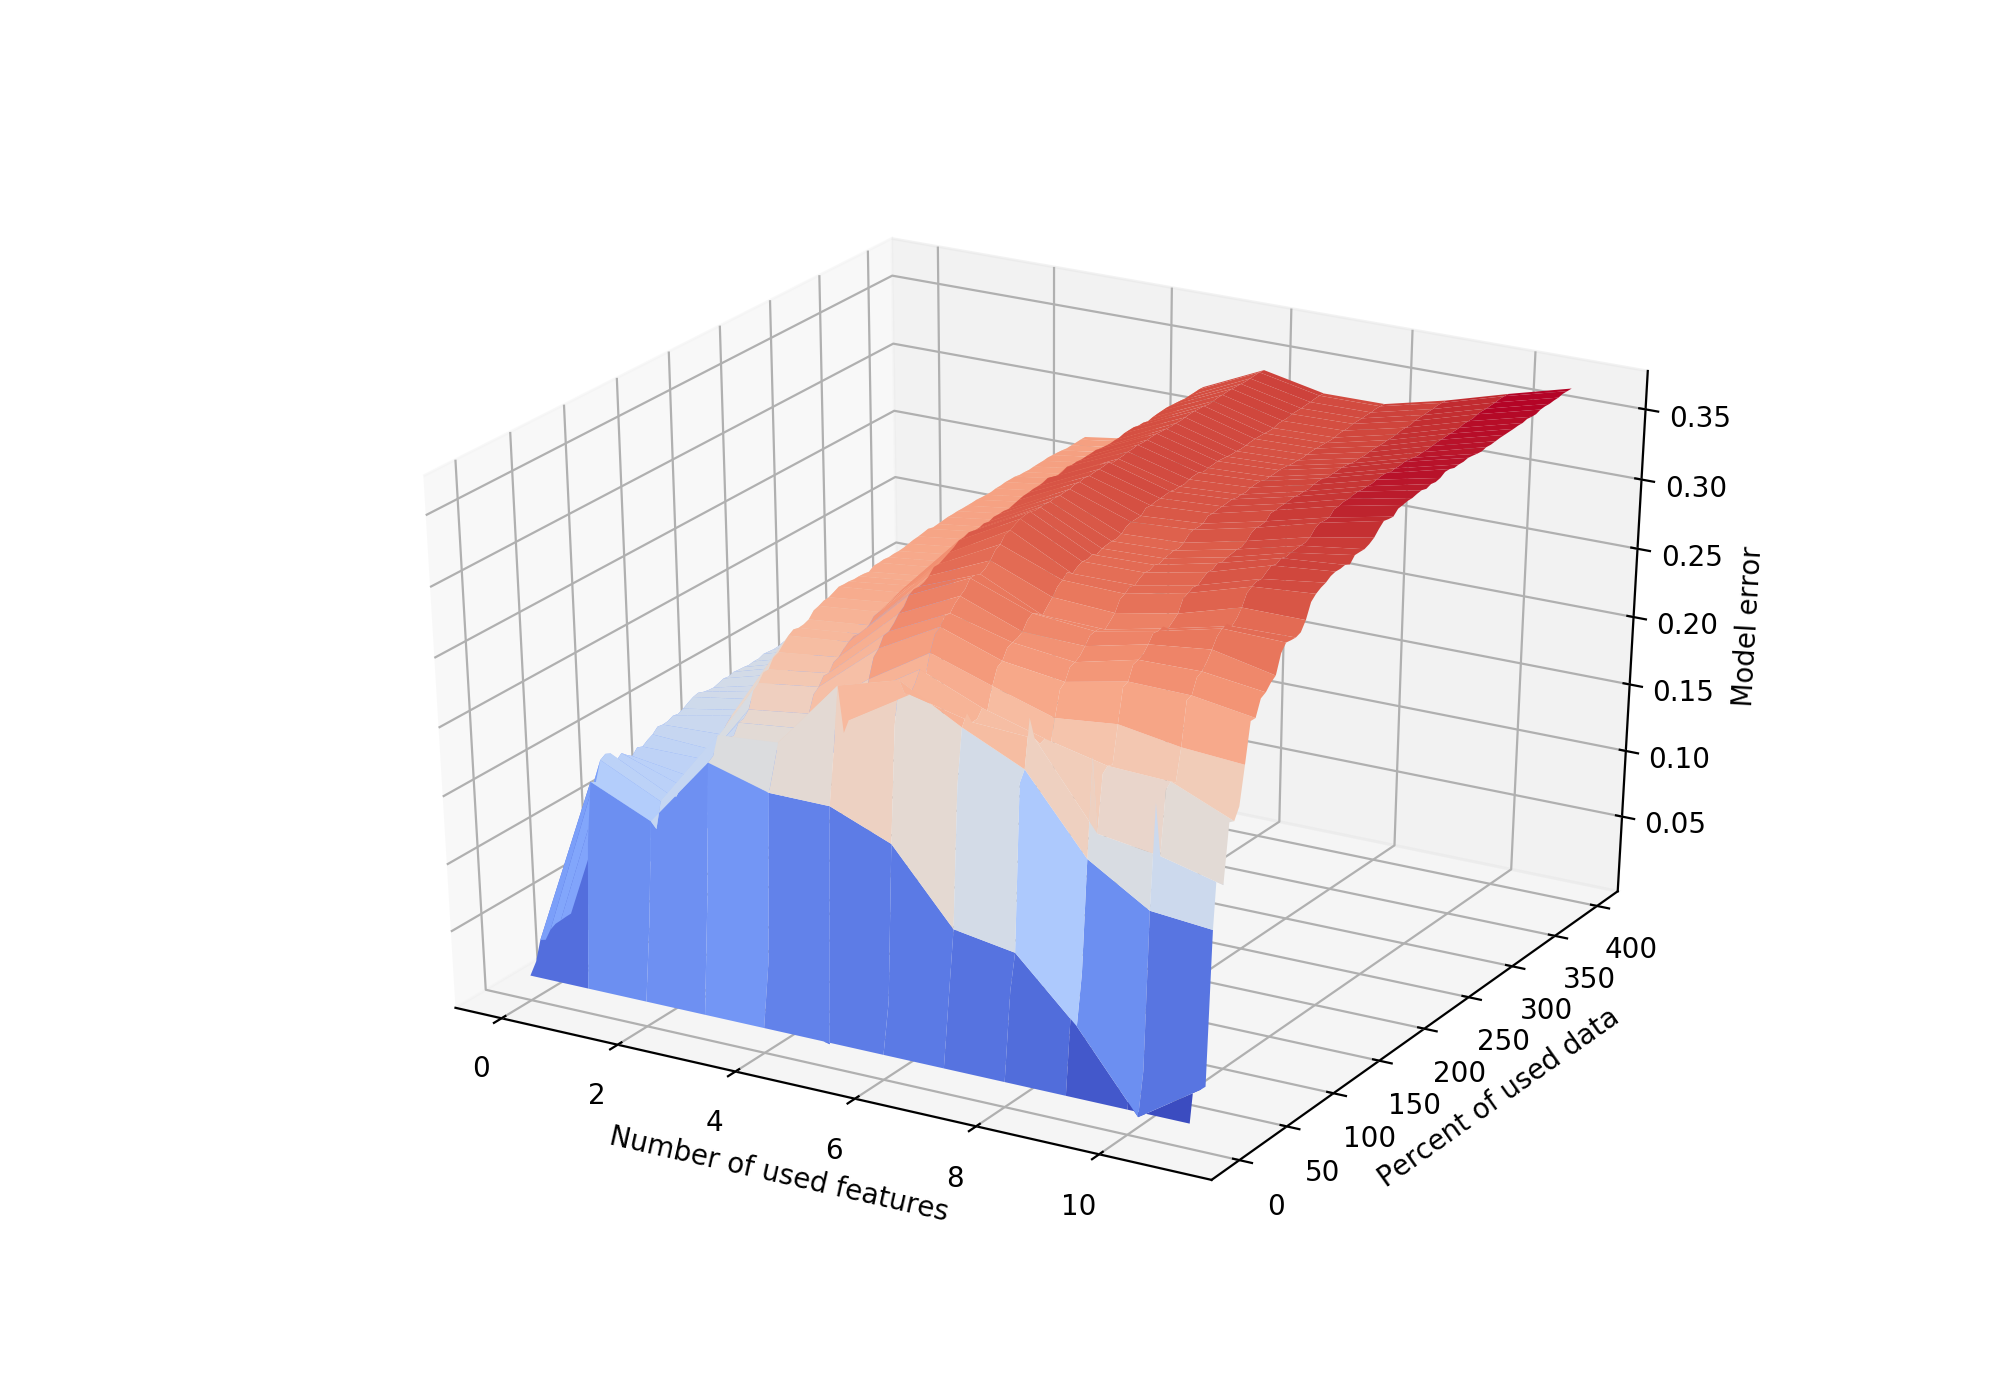

In [60]:
mean = np.mean(np.exp(-boston_error), axis=2)
std = np.std(np.exp(-boston_error), axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

## Servo dataset

In [45]:
name = 'servo'
X, y = ut.DataLoader(name = name)
X, y = ut.preprocess(X, y)

print(X.shape)

(167, 5)


### Observation of model weights

In [46]:
servo_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [47]:
servo_df.shape

(167, 6)

In [49]:
servo_weights, x = test_linear_model_weights(servo_df, 1, 5, num_of_tests=50)

In [50]:
set_plt_params()

<IPython.core.display.Javascript object>


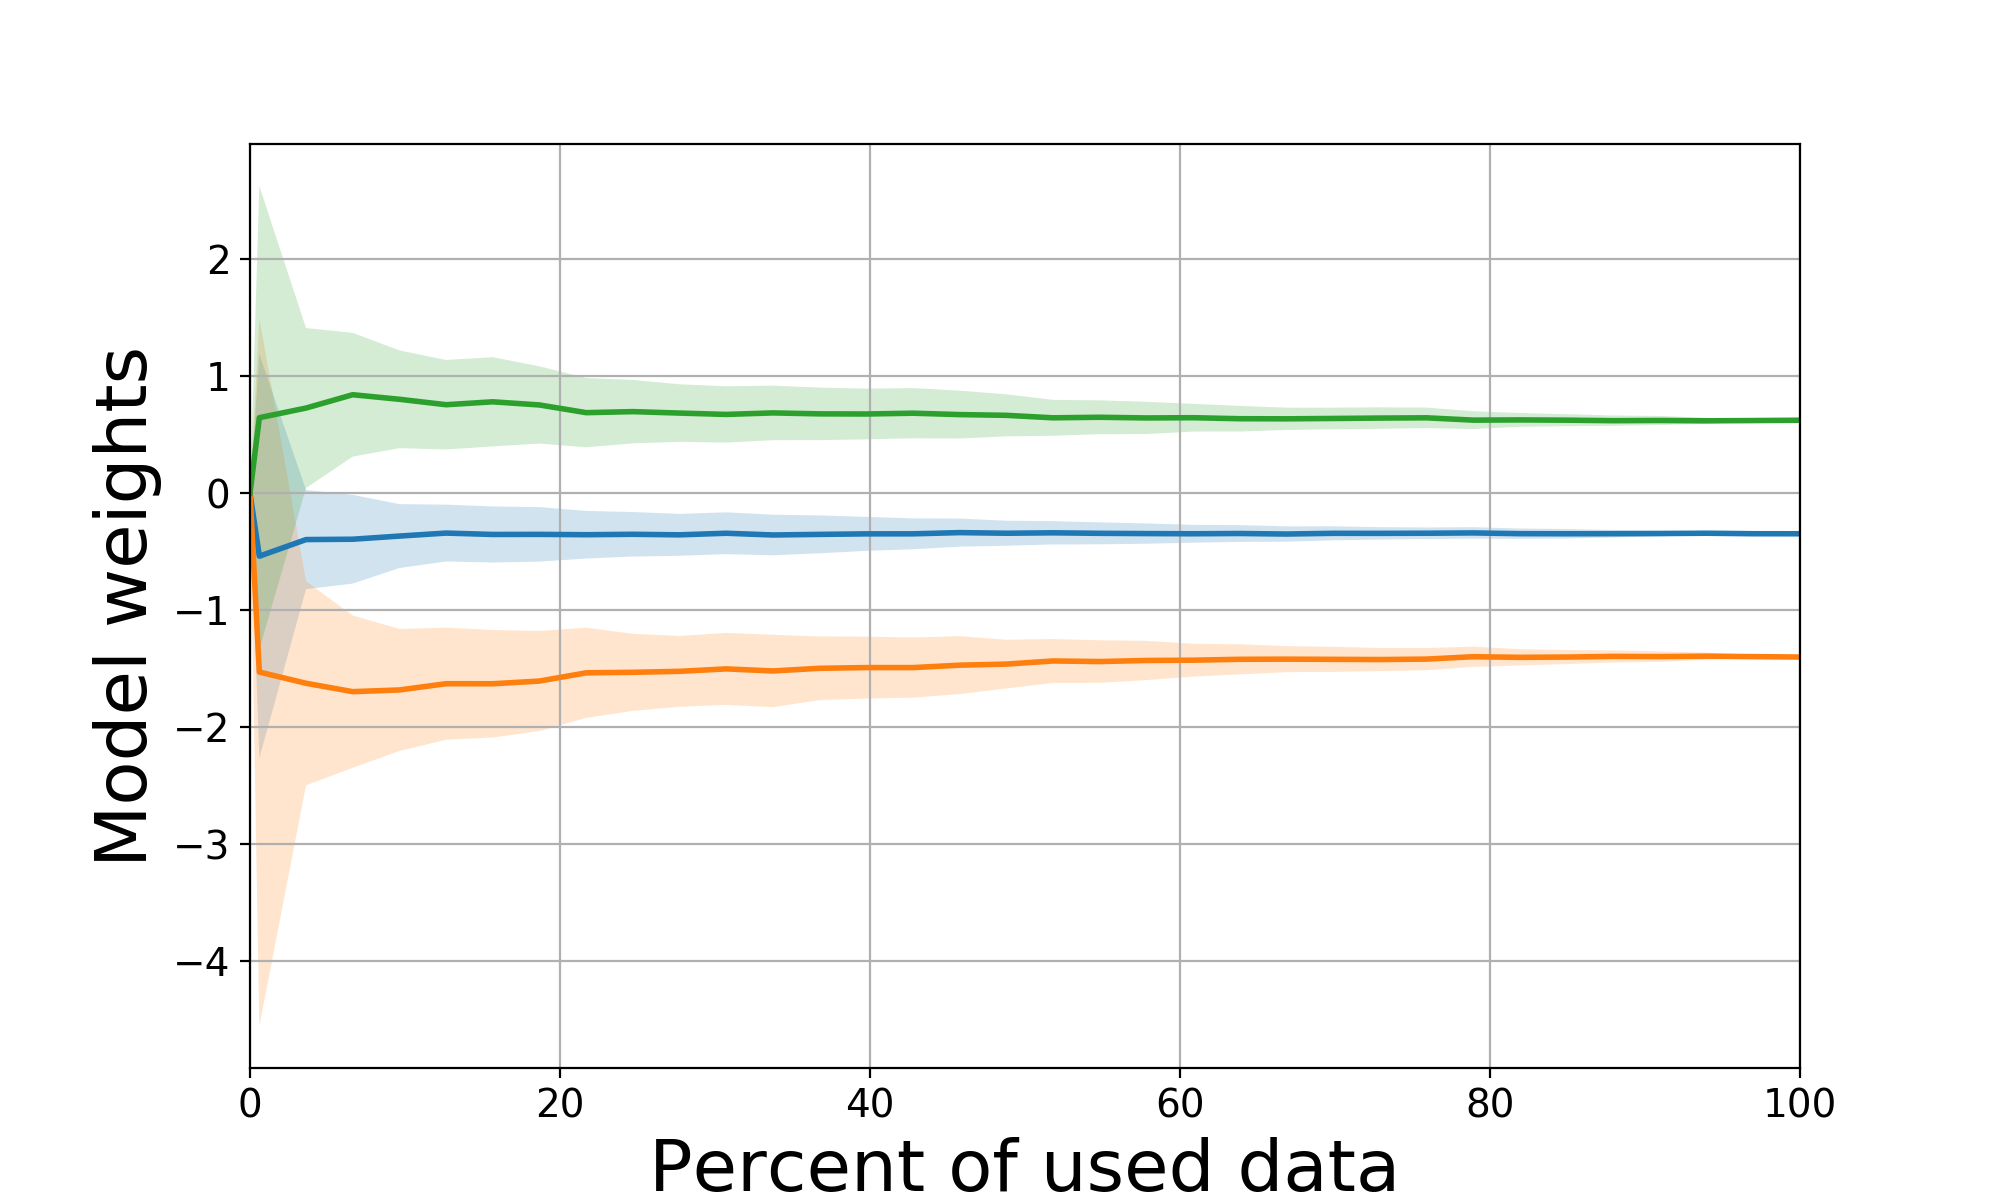

In [54]:
chosen_weights = [2,3,4]
    
mean = np.mean(servo_weights, axis=1)
std = np.std(servo_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [55]:
servo_train = servo_df.sample(130, random_state=1)
servo_test = servo_df.loc[~servo_df.index.isin(servo_train.index)]

In [56]:
servo_error, x = test_linear_model_error(servo_train, 1, 5, servo_test, num_of_tests=100)

In [61]:
set_plt_params()

<IPython.core.display.Javascript object>


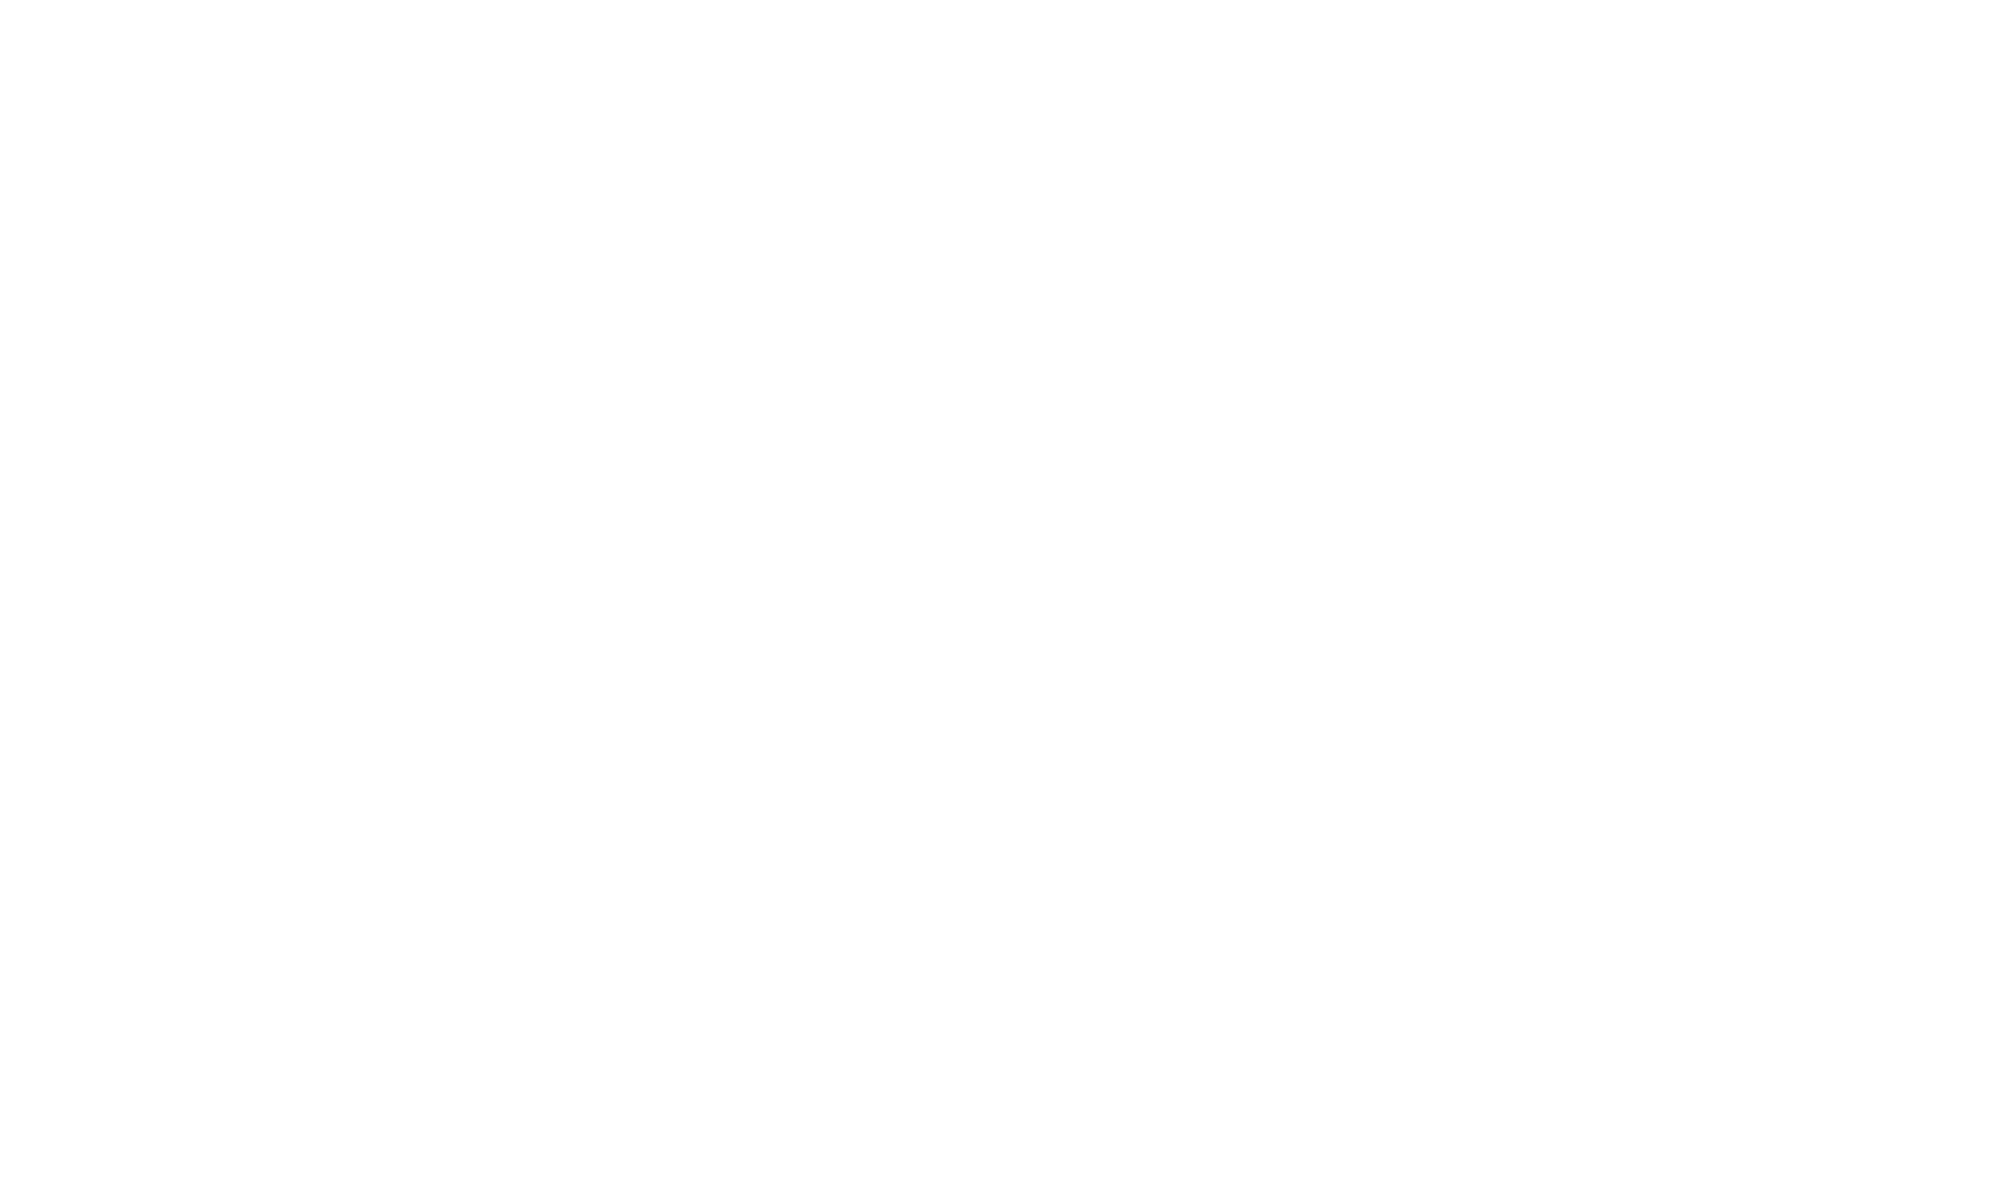

ValueError: x and y must have same first dimension, but have shapes (6096,) and (26, 5)

In [76]:
mean = np.mean(np.exp(-servo_error), axis=1)
std = np.std(np.exp(-servo_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [63]:
servo_error, features, size = test_linear_model_error_features(servo_df, servo_train, servo_test, 
                                                               1, 5, num_of_tests=5)

In [64]:
matplotlib.style.use('default')
plt.rcParams['figure.figsize'] = (10.0, 7.0)

<IPython.core.display.Javascript object>


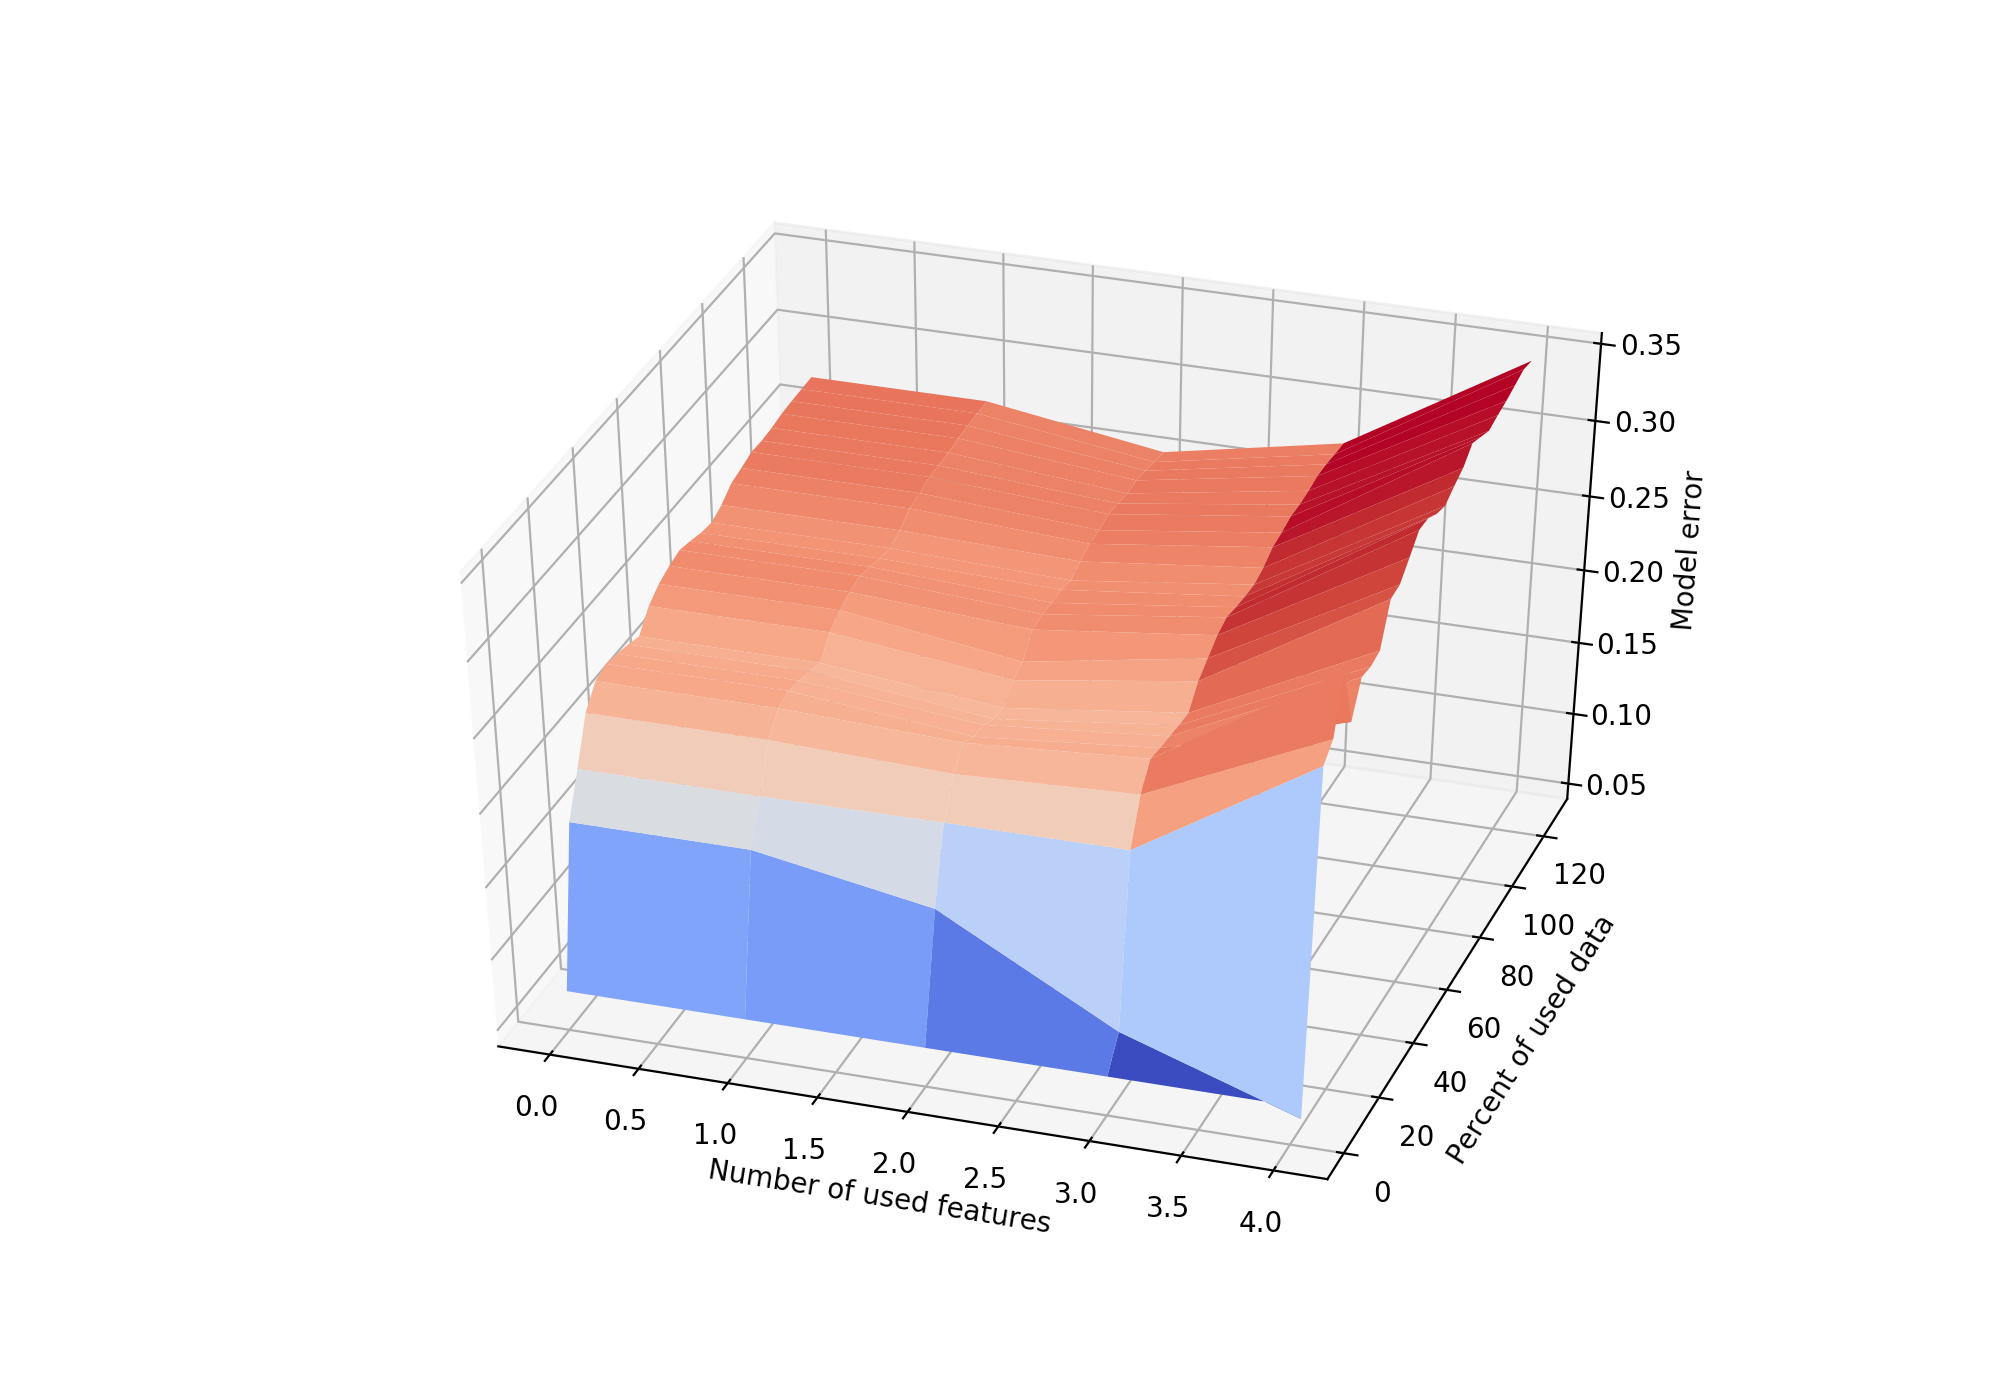

In [65]:
mean = np.mean(np.exp(-servo_error), axis=2)
std = np.std(np.exp(-servo_error), axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()

## Sberbank housing dataset

In [67]:
sberbank_train = pd.read_csv('datasets/housing_train.csv', index_col=0).fillna(0).select_dtypes(exclude=['object'])
#sberbank_test = pd.read_csv('datasets/housing_test.csv', index_col=0).fillna(0).select_dtypes(exclude=['object'])
#sberbank_df = pd.concat((sberbank_train, sberbank_test))

X, y = sberbank_train.iloc[:,:-1].values, sberbank_train.iloc[:,-1].values
X, y = ut.preprocess(X, y)

print(X.shape)

(30471, 34)


### Observation of model weights

In [68]:
sberbank_df = pd.DataFrame(np.hstack((X, y.reshape(1,-1).T)))

In [69]:
sberbank_df.shape

(30471, 35)

In [89]:
sberbank_weights, x = test_linear_model_weights(sberbank_df, 1, 500, num_of_tests=5)

In [90]:
set_plt_params()

In [91]:
np.mean(sberbank_weights, axis=1)[-1]

array([ 0.        ,  0.31321335,  0.09407167,  0.14932793, -0.03369069,
        0.37825945, -0.08966517, -0.16055045,  0.2229132 ,  0.04233351,
        0.69034587, -0.92204739,  0.08731543, -0.06959403, -0.0505381 ,
        0.00709835,  0.03883833, -0.09334761, -0.04592218,  0.07629864,
        0.04975254, -0.06229477,  0.51580547, -0.10255409, -0.37807344,
        0.17178546, -0.82154669,  0.02523473,  0.0948247 , -0.0781674 ,
       -0.13580834,  0.19689361,  0.30138362, -0.08583452])

<IPython.core.display.Javascript object>


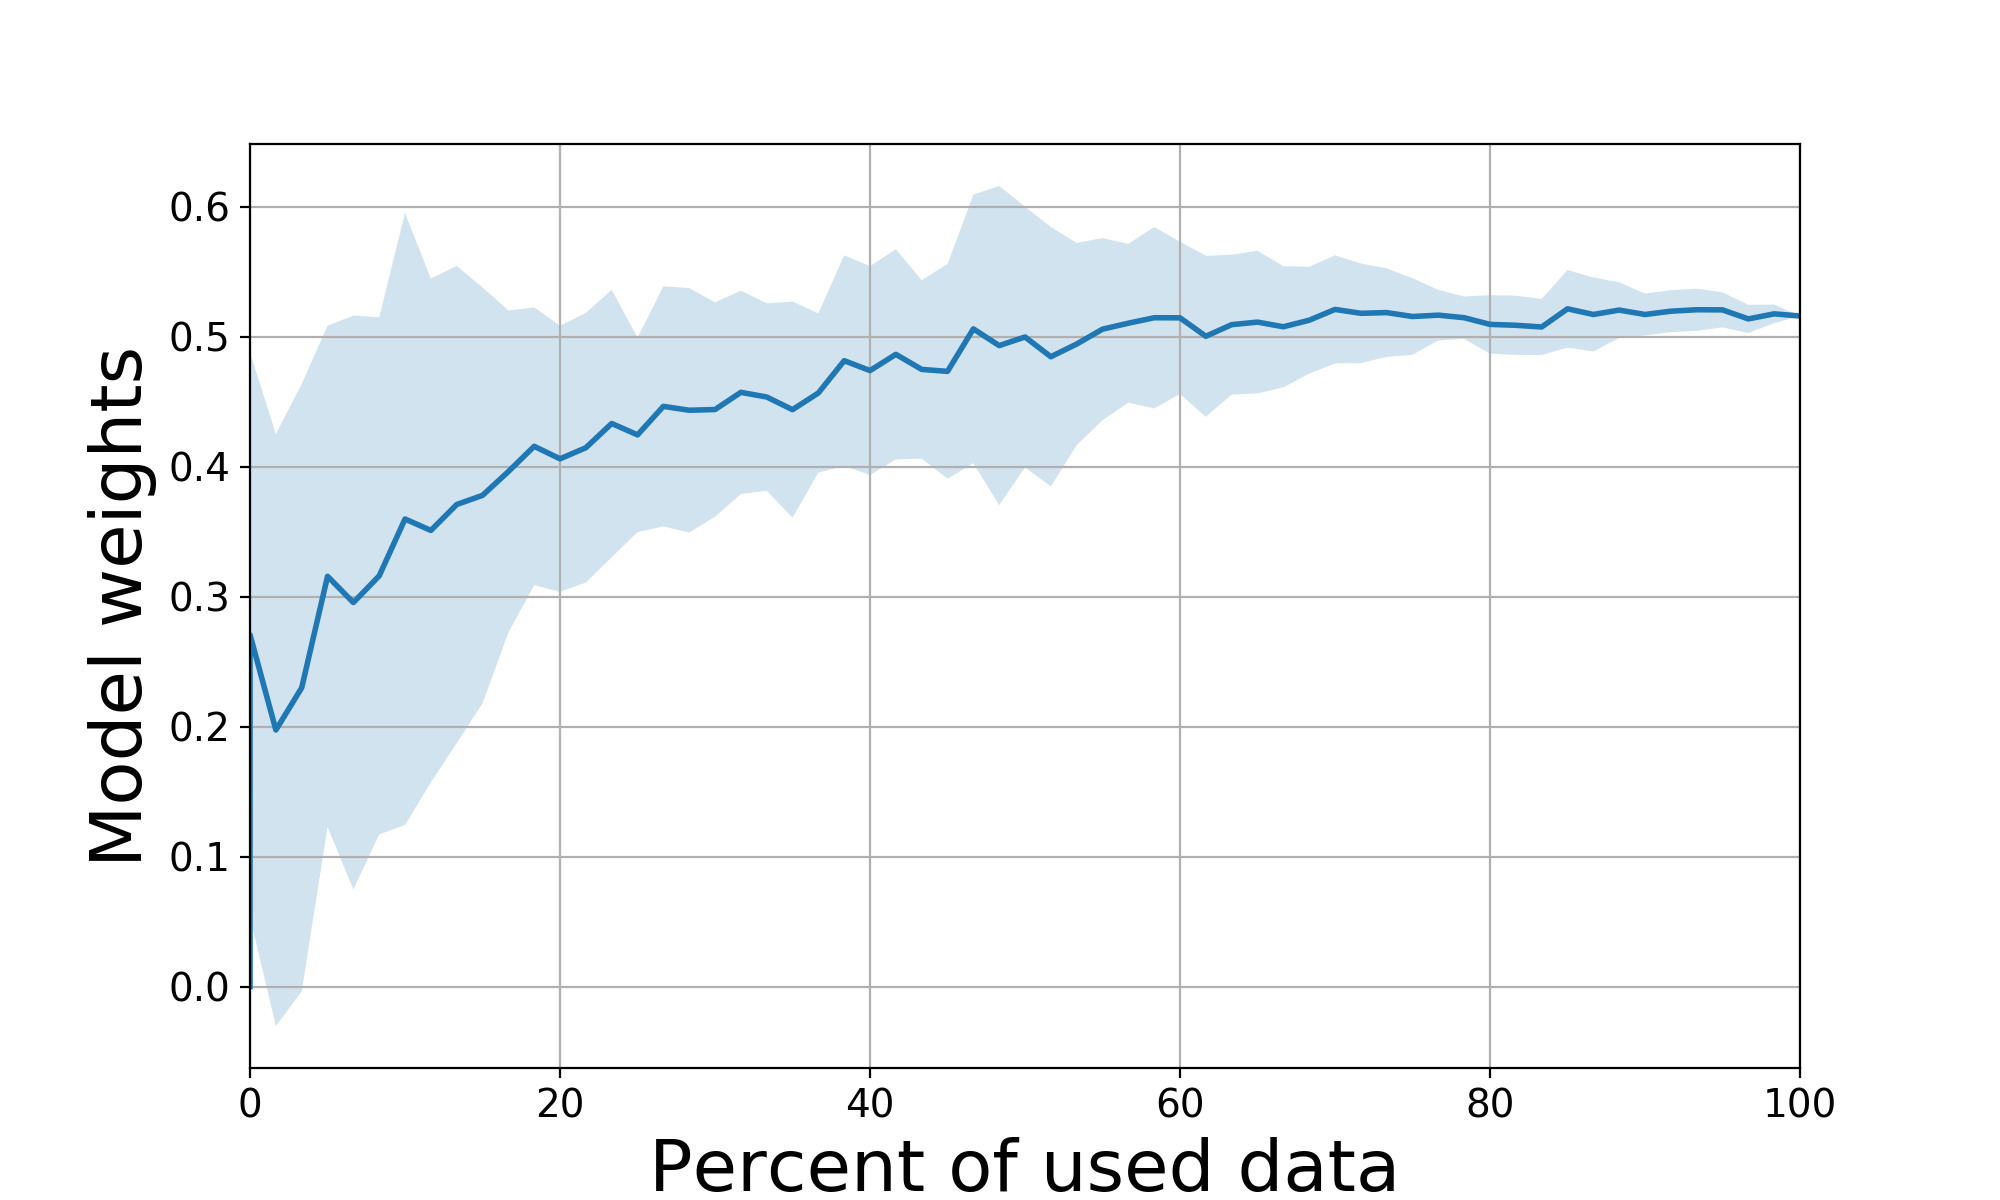

In [92]:
chosen_weights = [22]
    
mean = np.mean(sberbank_weights, axis=1)
std = np.std(sberbank_weights, axis=1)

for ind in chosen_weights:
    mean_ind = mean[:,[ind]].reshape(-1)
    std_ind = std[:,[ind]].reshape(-1)
    
    plt.plot(x, mean_ind)
    plt.fill_between(x, mean_ind - std_ind, mean_ind + std_ind, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model weights")
plt.grid()
plt.show()

### Observation of model error

In [93]:
sberbank_train = sberbank_df.sample(30000, random_state=42)
sberbank_test = sberbank_df.loc[~sberbank_df.index.isin(sberbank_train.index)]

In [94]:
sberbank_error, x = test_linear_model_error(sberbank_train, 1, 500, sberbank_test, num_of_tests=5)

In [95]:
set_plt_params()

<IPython.core.display.Javascript object>


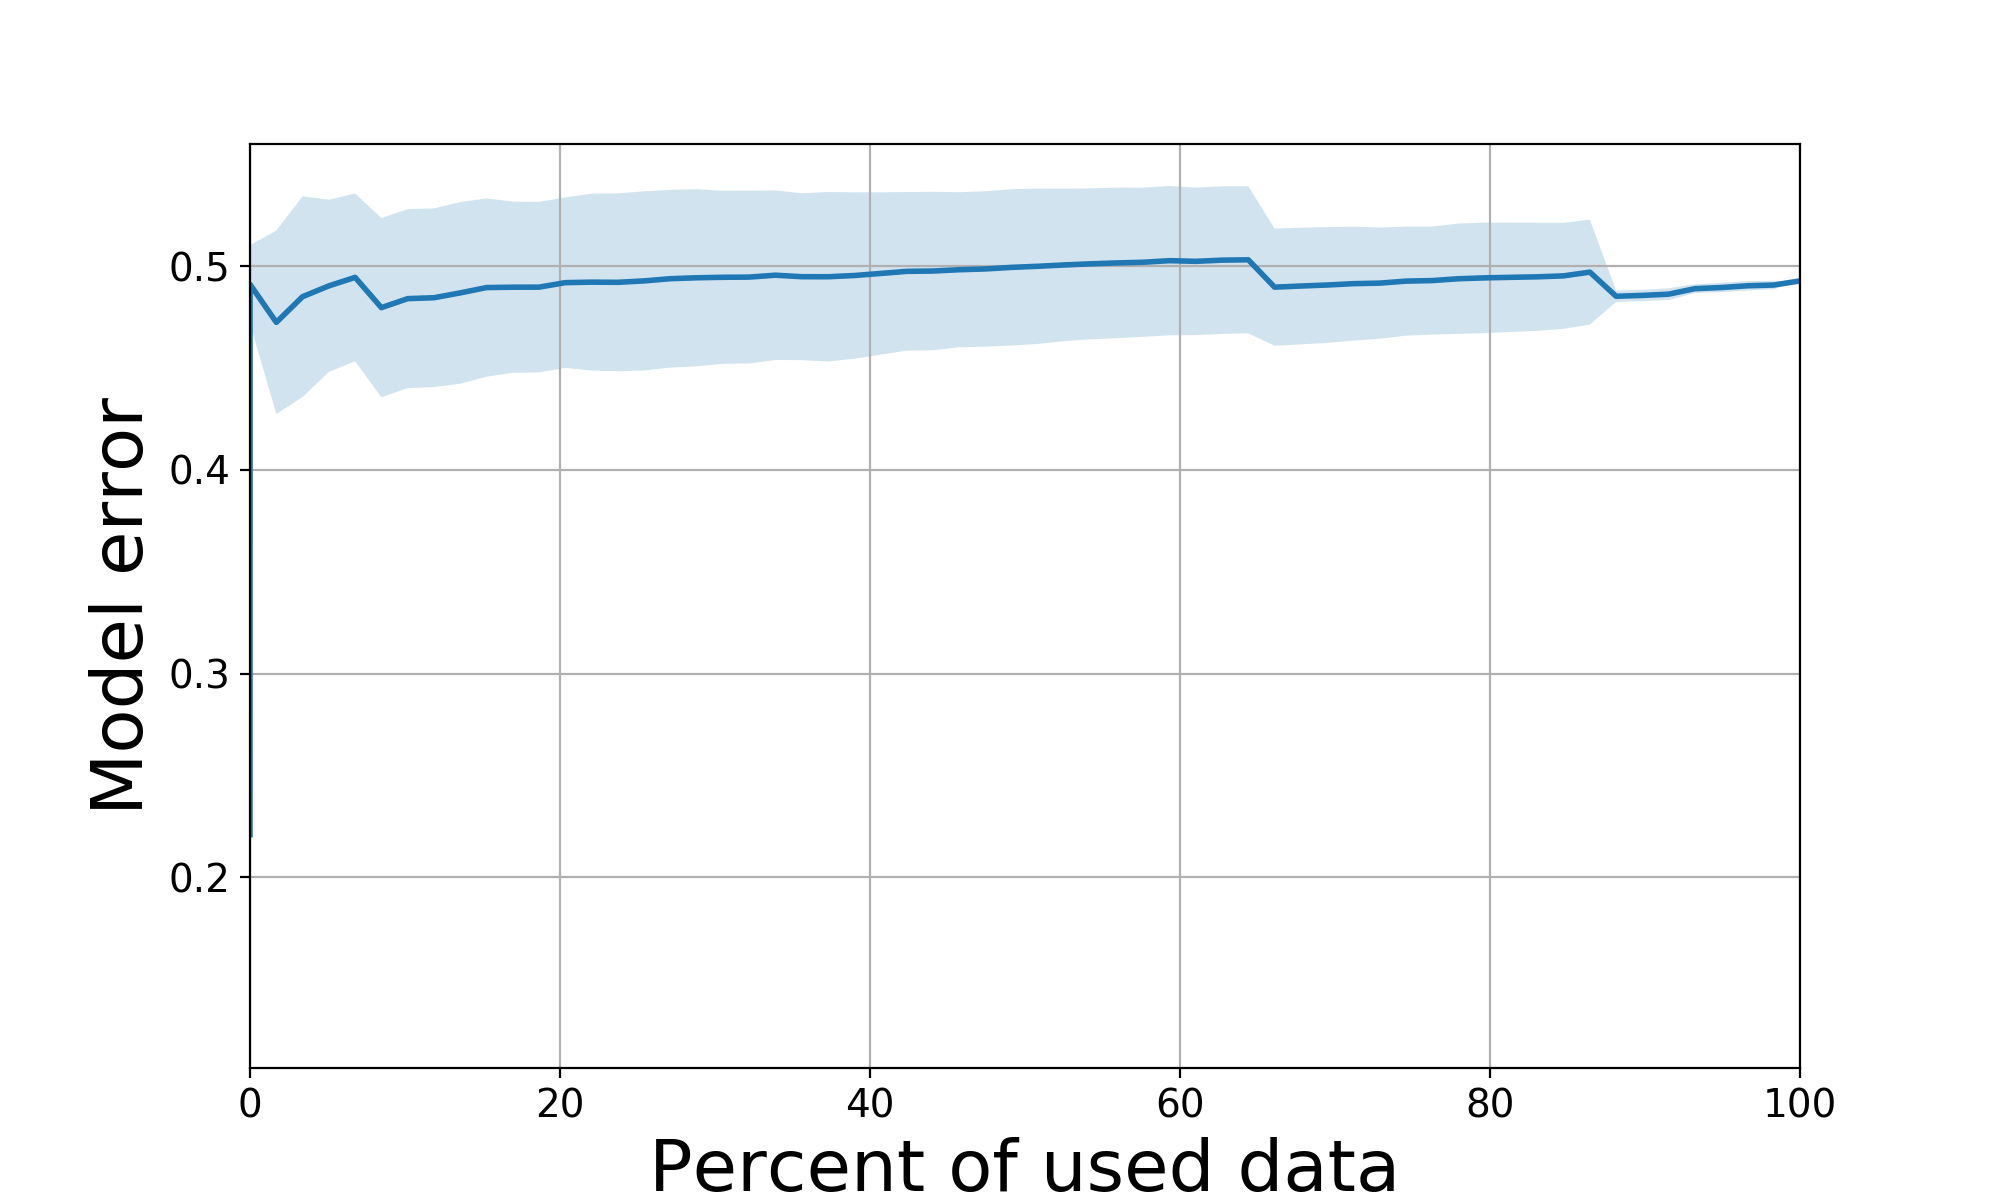

In [96]:
mean = np.mean(np.exp(-sberbank_error), axis=1)
std = np.std(np.exp(-sberbank_error), axis=1)

plt.plot(x, mean)
plt.fill_between(x, mean - std, mean + std, alpha=0.2)

axes = plt.axes()
axes.set_xlim([0, 100])

plt.xlabel("Percent of used data")
plt.ylabel("Model error")
plt.grid()
plt.show()

### 3D model error with num of features

In [97]:
sberbank_error, features, size = test_linear_model_error_features(sberbank_df, sberbank_train, sberbank_test, 
                                                                  1, 500, num_of_tests=5)

In [98]:
matplotlib.style.use('default')
plt.rcParams['figure.figsize'] = (10.0, 7.0)

<IPython.core.display.Javascript object>


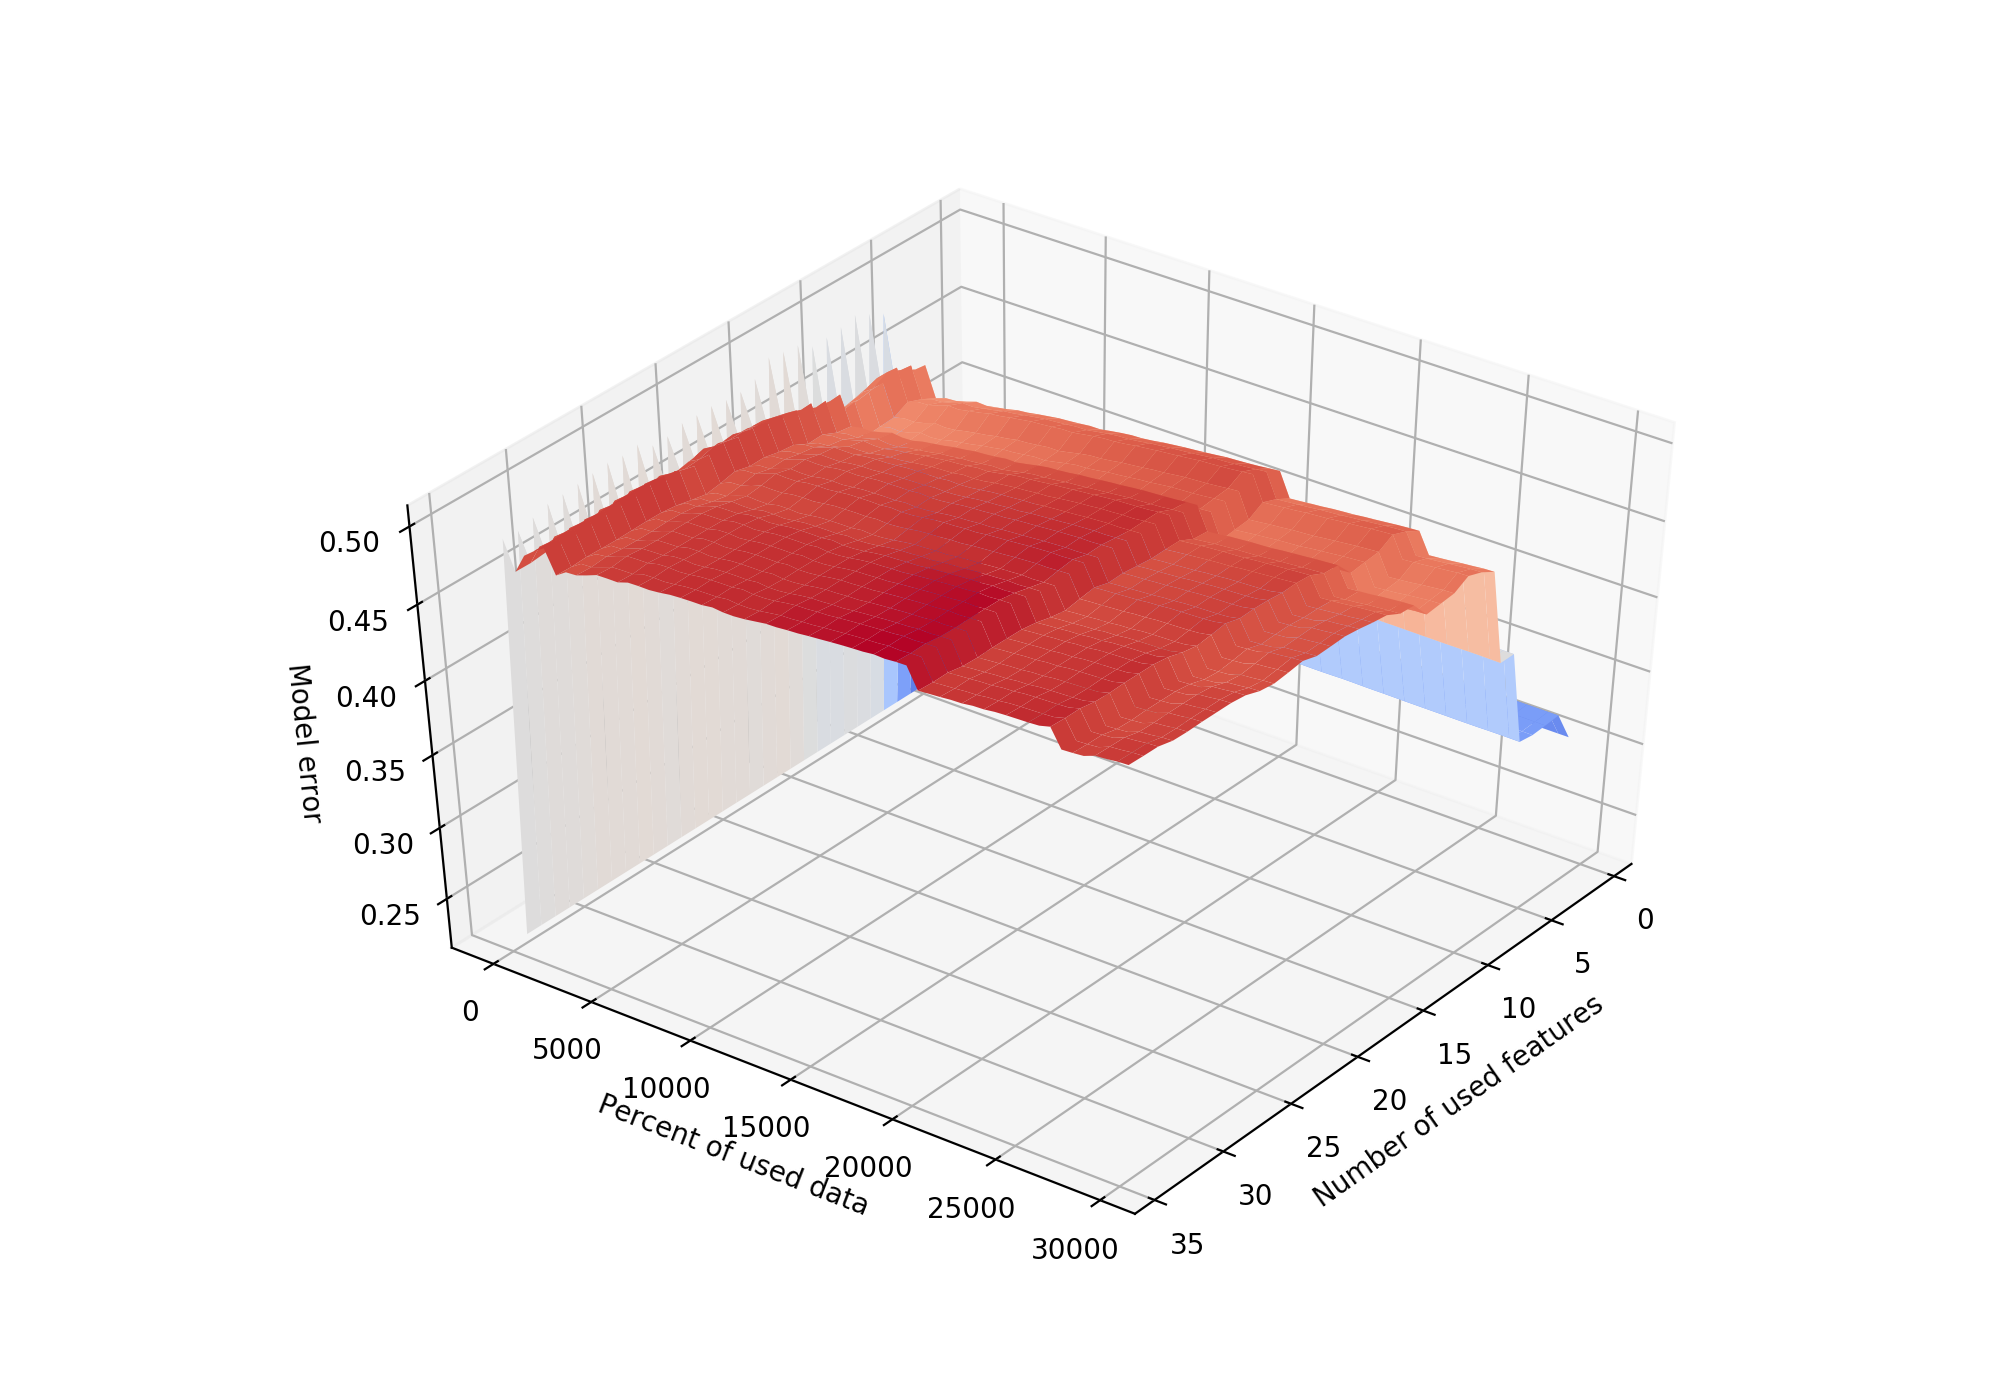

In [100]:
mean = np.mean(np.exp(-sberbank_error), axis=2)
std = np.std(np.exp(-sberbank_error), axis=2)

xv, yv = np.meshgrid(features, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#ax.plot_wireframe(xv, yv, mean)
ax.plot_surface(xv, yv, mean, cmap=cm.coolwarm, linewidth=0)

plt.xlabel("Number of used features")
plt.ylabel("Percent of used data")
ax.set_zlabel("Model error")
plt.show()